# Behavioral Analyses

This script loads the trial-level behavioral data and individual-level neural data and runs mixed effects models to test the effect of node type and network type on RT as well as the moderating effect of brain connectivity.

## Step 1: Set up

In [28]:
## Load packages
library(reshape2)
library(plyr)
library(QuantPsyc)
library(psych)
library(ggplot2)
library(effects)
library(lme4)
library(lmerTest)

## Set Working Directory to be location where CSV files are stored (change to the location you downloaded data to)
wd1<-"/Users/steventompson/Git/tompson_netlearn_fmri/data/subj_data/"
wd2<-"/Users/steventompson/Git/tompson_netlearn_fmri/data/netLearn_ppi_zscores/"

In [164]:
#Load utility functions from R_Utils folder
scriptDir<-"/Users/steventompson/Dropbox/R_Utils/"
source(paste(scriptDir,"rmd_utils.R",sep=""))
source(paste(scriptDir,"snl_rmd_custom_functions.R",sep=""))

Warning message:
“package ‘apcluster’ was built under R version 3.4.4”
Attaching package: ‘apcluster’

The following object is masked from ‘package:stats’:

    heatmap



In [29]:
sessionInfo()

R version 3.4.0 (2017-04-21)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.14.6

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.4/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.4/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] lmerTest_3.0-1 lme4_1.1-19    Matrix_1.2-15  effects_4.0-0  carData_3.0-2 
 [6] ggplot2_3.1.0  psych_1.8.12   QuantPsyc_1.5  MASS_7.3-51.1  boot_1.3-20   
[11] plyr_1.8.4     reshape2_1.4.3

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3      tidyselect_0.2.5  repr_0.19.1       purrr_0.2.5      
 [5] splines_3.4.0     lattice_0.20-38   colorspace_1.4-0  htmltools_0.3.6  
 [9] base64enc_0.1-3   survival_2.43-3   rlang_0.3.1       pillar_1.3.1     
[13] nloptr_1.2.1      foreign_0.8

In [30]:
## Load trial-level behavioral data
tdf<-read.csv(paste(wd1,"tompson_netlearn_fmri_trial_data.csv",sep=""))

tdfNS<-tdf[tdf$Cond=="NS",]
tdfSoc<-tdf[tdf$Cond=="Soc",]
head(tdf) 

X,path,pID,walk,trialNum,altered,correct_raw,onset_raw,resp_raw,rt_raw,order,Cond,pre,transition,grouping
1,img/18_circ.png,1,2,0,False,0,0.00288415,NA,NA,0,NS,0,0,x
2,img/4_circ.png,1,1,1,False,0,1.51719999,4,977.3271,1,NS,0,0,x
3,img/13_circ.png,1,0,2,False,1,3.01679420,1,478.4188,2,NS,0,0,x
4,img/18_circ_rotated.png,1,2,3,True,0,4.51468945,1,681.2568,3,NS,0,0,x
5,img/15_circ.png,1,3,4,False,0,6.01897907,4,327.5101,4,NS,0,0,x
6,img/18_circ.png,1,2,5,False,1,7.51567698,1,263.9382,5,NS,0,0,x


## Step 2: Exclude bad subjects and trials

In [31]:
#################################################
### check summary data for each subject to determine who to exclude
#################################################

print('')
print('Combined Accuracy')
print(tapply(tdf$correct,tdf$pID,function(i){sum(i,na.rm=T)/2000})) #percent correct trials

print('')
print('Non-Social Accuracy')
print(tapply(tdfNS$correct,tdfNS$pID,function(i){sum(i,na.rm=T)/1000})) #percent correct trials

print('')
print('Social Accuracy')
print(tapply(tdfSoc$correct,tdfSoc$pID,function(i){sum(i,na.rm=T)/1000})) #percent correct trials

[1] ""
[1] "Combined Accuracy"
     1      2      4      5      8      9     11     12     13     15     16 
0.7540 0.9230 0.8975 0.9010 0.9005 0.9085 0.8535 0.8845 0.3640 0.6020 0.9025 
    18     19     20     21     23     24     25     26     27     28     29 
0.8705 0.8610 0.4290 0.9580 0.7220 0.8960 0.9280 0.7190 0.8875 0.2390 0.9295 
    30     31     32     33     34     35     36     37     39 
0.8950 0.8590 0.7935 0.9025 0.7565 0.8320 0.8385 0.6340 0.9120 
[1] ""
[1] "Non-Social Accuracy"
    1     2     4     5     8     9    11    12    13    15    16    18    19 
0.753 0.916 0.887 0.926 0.913 0.873 0.886 0.884 0.728 0.645 0.892 0.861 0.881 
   20    21    23    24    25    26    27    28    29    30    31    32    33 
0.345 0.958 0.748 0.892 0.925 0.760 0.869 0.286 0.939 0.896 0.874 0.823 0.923 
   34    35    36    37    39 
0.636 0.818 0.801 0.636 0.910 
[1] ""
[1] "Social Accuracy"
    1     2     4     5     8     9    11    12    15    16    18    19    20 
0.755 0.93

In [32]:
#################################################
### Exclude subjects with fewer than 70% correct responses

#NOTE: 18 subjects had greater than 70% correct
#NOTE: 2 subjects missed greater than 50% of trials (20=43%, 28=24%)
#NOTE: 2 subjects missed greater than 30% of trials (15=60%, 37=64%) but will keep them in for now
#NOTE: 1 subject had to abort because they were feeling claustrophobic (13)
#NOTE: 1 subject had to be excluded due to brain artifact (4=missing back part of parietal cortex)
#################################################

tdf<-subset(tdf,pID!= 1)
tdf<-subset(tdf,pID!= 4)
tdf<-subset(tdf,pID!= 13)
#tdf<-subset(tdf,pID!= 15)
tdf<-subset(tdf,pID!= 20)
tdf<-subset(tdf,pID!= 28)
#tdf<-subset(tdf,pID!= 37)

In [33]:
#################################################
### Exclude bad trials and trials we won't use in analyses
#################################################

#remove incorrect trials
tdf2<-subset(tdf,tdf$correct_raw==1)

#remove altered trials
tdf2<-subset(tdf2,tdf2$altered=="False")


#Get rid of impossible reaction times (i.e., less than 100, >1500)
tdf2 <- subset(tdf2, rt_raw < 1500)
tdf2 <- subset(tdf2, rt_raw > 100)

##remove Rts > 3 Sd from the mean
tdf2 = ddply(tdf2, .(pID), transform, sRT = scale(rt_raw))
tdf2= subset(tdf2, abs(sRT) < 3)

#check # of transition trials left after cleaning
print('# of transition trials')
print(tapply(tdf2$grouping,tdf2$pID,function(i){sum(i=="transition",na.rm=T)})) #number of transition trials

#convert trial grouping variable to a factor
tdf2$grouping <- factor(tdf2$grouping, levels = c("x", "transition"))


rm(tdf,tdfNS,tdfSoc)

print('')
print(paste('Total # of subjects:',length(unique(tdf2$pID))))

[1] "# of transition trials"
  2   5   8   9  11  12  15  16  18  19  21  23  24  25  26  27  29  30  31  32 
 97  99 108 103  97  99  65  91  89  83 104  97  94  99  99  98  97 107  86  82 
 33  34  35  36  37  39 
 85  93  90  89  67  95 
[1] ""
[1] "Total # of subjects: 26"


## Step 3: Load and merge neural data

In [34]:
#################################################
### Load data
#################################################

#Load IDs to link behavioral and neural data
subjIDs<-read.csv(paste(wd1,"netLearn_IDs_26subjs.csv",sep="/"))

#Load head motion data file
hmData<-read.csv(paste(wd1,"netLearn_headMotion_26subjs.csv",sep="/"))

#Define function for creating df
create_df<-function(dname1,dname2,df1,df2){
  filepath<-paste(wd2,"netLearn_",dname1,
                  "_zscores_26subjs_",dname2,".csv",sep="")
  new.df<-read.csv(filepath,header=T,as.is=T)
  new.df<-cbind(df1,new.df)
  new.df<-merge(new.df,df2,by="pID")
  new.df$task<-dname1
  return(new.df)
}

# Load neural data and merge with behavioral/head motion data
combData_gc<-create_df(dname1="combData",dname2="sighubs_global_conn",df1=subjIDs,df2=hmData)
diffData_gc<-create_df("diffData","sighubs_global_conn",subjIDs,hmData)
nsData_gc<-create_df("NSData","sighubs_global_conn",subjIDs,hmData)
socData_gc<-create_df("SocData","sighubs_global_conn",subjIDs,hmData)

combData_ss<-create_df("combData","sighubs_to_sighubs",subjIDs,hmData)
diffData_ss<-create_df("diffData","sighubs_to_sighubs",subjIDs,hmData)
nsData_ss<-create_df("NSData","sighubs_to_sighubs",subjIDs,hmData)
socData_ss<-create_df("SocData","sighubs_to_sighubs",subjIDs,hmData)

In [35]:
#################################################
# Combine neural dataframes
#################################################

longData_gc<-rbind(socData_gc,nsData_gc)
longData_ss<-rbind(socData_ss,nsData_ss)

longData_gc$task<-gsub('Data','',longData_gc$task)
longData_ss$task<-gsub('Data','',longData_ss$task)

In [36]:
#################################################
# Convert key variables to z-scores
#################################################

create_zscores<-function(varlist,df1){
  newlist<-c()
  for(var in varlist){
    newvar<-paste(var,"z",sep="_")
    newlist<-c(newlist,newvar)
    df1[,newvar]<-as.numeric(Make.Z(df1[,var]))
    
    newvar2<-paste(var,"c",sep="_")
    newlist<-c(newlist,newvar2)
    df1[,newvar2]<-as.numeric(scale(df1[,var],center=TRUE,scale=FALSE))
  }
  return(list(newlist,df1))
}

hublist1<-c("combhubs_global","Hippocampus_L_global","Hippocampus_R_global",
            "diffhubs_global","TPJ_L_global","TPJ_R_global",
            "diffhubs_ns_global","dmPFC_L_global","dmPFC_R_global","lPFC_L_global","lPFC_R_global")

hublist2<-c("Hippocampus_L_X_combhubs","Hippocampus_L_X_nshubs","Hippocampus_L_X_sochubs",
            "Hippocampus_R_X_combhubs","Hippocampus_R_X_nshubs","Hippocampus_R_X_sochubs",
            "ws_combhubs","combhubs_X_nshubs","combhubs_X_sochubs",
            "ws_nshubs","nshubs_X_sochubs","ws_sochubs")

zscores<-create_zscores(hublist1,longData_gc)
zvars<-zscores[[1]]
longData_gc<-zscores[[2]]

zscores<-create_zscores(hublist2,longData_ss)
zvars<-zscores[[1]]
longData_ss<-zscores[[2]]

In [37]:
#################################################
# Merge neural and trial-level data
#################################################

combData2_gc<-merge(tdf2,longData_gc,by.x = c("pID","Cond"),by.y=c("pID","task"))
combData2_ss<-merge(tdf2,longData_ss,by.x = c("pID","Cond"),by.y=c("pID","task"))

head(combData2_gc)

pID,Cond,X.x,path,walk,trialNum,altered,correct_raw,onset_raw,resp_raw,⋯,diffhubs_ns_global_z,diffhubs_ns_global_c,dmPFC_L_global_z,dmPFC_L_global_c,dmPFC_R_global_z,dmPFC_R_global_c,lPFC_L_global_z,lPFC_L_global_c,lPFC_R_global_z,lPFC_R_global_c
11,NS,2002,img/5_circ.png,9,1,False,1,1.513404,1,⋯,-1.075166,-2.225933,-0.7229176,-1.329685,-1.446452,-2.636942,0.4752756,0.8446609,-0.5426352,-1.032048
11,NS,2003,img/1_circ.png,8,2,False,1,3.016448,1,⋯,-1.075166,-2.225933,-0.7229176,-1.329685,-1.446452,-2.636942,0.4752756,0.8446609,-0.5426352,-1.032048
11,NS,2005,img/1_circ.png,8,4,False,1,6.018421,1,⋯,-1.075166,-2.225933,-0.7229176,-1.329685,-1.446452,-2.636942,0.4752756,0.8446609,-0.5426352,-1.032048
11,NS,2007,img/3_circ.png,4,6,False,1,9.018356,1,⋯,-1.075166,-2.225933,-0.7229176,-1.329685,-1.446452,-2.636942,0.4752756,0.8446609,-0.5426352,-1.032048
11,NS,2009,img/17_circ.png,1,8,False,1,12.018660,1,⋯,-1.075166,-2.225933,-0.7229176,-1.329685,-1.446452,-2.636942,0.4752756,0.8446609,-0.5426352,-1.032048
11,NS,2010,img/18_circ.png,3,9,False,1,13.518142,1,⋯,-1.075166,-2.225933,-0.7229176,-1.329685,-1.446452,-2.636942,0.4752756,0.8446609,-0.5426352,-1.032048


## Step 4: Behavioral Analyses

In [38]:
#################################################
### Clean trial df
#################################################

# Create function to clean df
clean_trial_df<-function(df1){
  # Add order info to trial-level df
  df1$order<-NA
  for(subj in unique(df1$pID)){
    df1$order[df1$pID==subj]<-subjIDs$CondNum[subjIDs$pID==subj]
  }
  
  #z-score variables
  df1$strial<-as.numeric(scale(df1$trialNum))
  
  #contrast coding
  contrasts(df1$grouping) <- contr.helmert(2) 
  contrasts(df1$grouping)
  
  df1$Cond<-factor(df1$Cond)
  contrasts(df1$Cond) <- contr.helmert(2) 
  contrasts(df1$Cond)
  
  df1$order<-factor(df1$order)
  contrasts(df1$order) <- contr.helmert(2) 
  contrasts(df1$order)
  
  #log-transform variables
  df1$rt_log<-log(df1$rt_raw)
  df1$rt_log<-df1$rt_log-mean(df1$rt_log)
  return(df1)
}

tdf2<-clean_trial_df(tdf2)

In [154]:
#################################################
### Compute xixed effects model for Grouping (Node Type) x Cond (Network Type) X Order (Social First vs. Non-Social First) x Trial Number
#################################################

mm1_log<- lmer(rt_log ~  grouping*Cond*strial + order + (1 + grouping + Cond + strial| pID), data = tdf2)

print('Both Tasks')
round(summary(mm1_log)$coefficients,3)

[1] "Both Tasks"


,Estimate,Std. Error,df,t value,Pr(>|t|)
(Intercept),0.021,0.029,23.921,0.726,0.475
grouping1,0.015,0.003,24.461,4.382,0.000
Cond1,-0.002,0.008,28.167,-0.203,0.841
strial,-0.021,0.005,32.989,-3.992,0.000
order1,-0.019,0.028,23.994,-0.679,0.503
grouping1:Cond1,-0.002,0.002,31212.004,-0.802,0.423
grouping1:strial,0.004,0.002,31712.291,1.778,0.075
Cond1:strial,-0.003,0.002,31158.127,-1.189,0.235
grouping1:Cond1:strial,0.001,0.002,31097.609,0.360,0.719


In [155]:
#################################################
### Compute mixed effects model for Social and Non-Social Networks separately
#################################################

socData2<-tdf2[tdf2$Cond=="Soc",]
nsData2<-tdf2[tdf2$Cond=="NS",]

mm1_log_ns= lmer(rt_log ~  grouping*strial + order + (1 + grouping*strial | pID), data = nsData2)
mm1_log_soc= lmer(rt_log ~  grouping*strial + order + (1 + grouping*strial | pID), data = socData2)

print('Non-Social Task')
round(summary(mm1_log_ns)$coefficients,3)

print('Social Task')
round(summary(mm1_log_soc)$coefficients,3)

singular fit


[1] "Non-Social Task"


,Estimate,Std. Error,df,t value,Pr(>|t|)
(Intercept),0.023,0.029,24.154,0.772,0.447
grouping1,0.016,0.006,23.866,2.901,0.008
strial,-0.019,0.008,24.684,-2.310,0.030
order1,-0.024,0.027,24.076,-0.877,0.389
grouping1:strial,0.003,0.004,17.615,0.727,0.477


[1] "Social Task"


,Estimate,Std. Error,df,t value,Pr(>|t|)
(Intercept),0.018,0.030,23.983,0.609,0.548
grouping1,0.013,0.004,25.614,3.537,0.002
strial,-0.023,0.008,24.751,-2.733,0.011
order1,0.003,0.027,23.844,0.106,0.916
grouping1:strial,0.005,0.003,53.933,1.561,0.124


## Step 5: Brain Connectivity Moderation Analyses

In [41]:
#################################################
### Clean merged trial/neural data
#################################################
combData2_gc<-clean_trial_df(combData2_gc)
combData2_ss<-clean_trial_df(combData2_ss)


nsData2_gc<-combData2_gc[combData2_gc$Cond=='NS',]
socData2_gc<-combData2_gc[combData2_gc$Cond=='Soc',]

nsData2_ss<-combData2_ss[combData2_ss$Cond=='NS',]
socData2_ss<-combData2_ss[combData2_ss$Cond=='Soc',]

In [43]:
#################################################
### Loop over list of hubs and save results in list
#################################################

full_model_output<-list()
grouping_main_effect<-list()
brain_main_effect<-list()
groupxcond_int<-list()
groupxbrain_int<-list()
condxbrain_int<-list()
groupxbrainxcond_int<-list()

hublist1<-c("combhubs_global_z","Hippocampus_L_global_z","Hippocampus_R_global_z",
            "diffhubs_global_z","TPJ_L_global_z","TPJ_R_global_z",
            "diffhubs_ns_global_z","dmPFC_L_global_z","dmPFC_R_global_z","lPFC_L_global_z","lPFC_R_global_z")

#hublist2<-c("Hippocampus_L_X_combhubs_z","Hippocampus_L_X_nshubs_z","Hippocampus_L_X_sochubs_z",
#            "Hippocampus_R_X_combhubs_z","Hippocampus_R_X_nshubs_z","Hippocampus_R_X_sochubs_z",
#            "ws_combhubs_z","combhubs_X_nshubs_z","combhubs_X_sochubs_z",
#            "ws_nshubs_z","nshubs_X_sochubs_z","ws_sochubs_z")

hublist2<-c("ws_combhubs_z","ws_nshubs_z","ws_sochubs_z")

print("Node Strength analyses for node type x network type interaction")
for(x in hublist1){
  mm1_cov= lmer(combData2_gc[,"rt_log"] ~  
                  combData2_gc[,"grouping"]*combData2_gc[,"Cond"]*combData2_gc[,"order"]*combData2_gc[,"strial"]*combData2_gc[,x] +
                  (1 + combData2_gc[,"grouping"] + combData2_gc[,"Cond"]+ combData2_gc[,"strial"]| combData2_gc[,"pID"]))
  full_model_output[[paste("all",x,sep="_")]]<-mm1_cov
  grouping_main_effect[[paste("all",x,sep="_")]]<-summary(mm1_cov)$coefficients[2,]
  brain_main_effect[[paste("all",x,sep="_")]]<-summary(mm1_cov)$coefficients[6,]
  groupxcond_int[[paste("all",x,sep="_")]]<-summary(mm1_cov)$coefficients[7,]
  groupxbrain_int[[paste("all",x,sep="_")]]<-summary(mm1_cov)$coefficients[13,]
  condxbrain_int[[paste("all",x,sep="_")]]<-summary(mm1_cov)$coefficients[14,]
  groupxbrainxcond_int[[paste("all",x,sep="_")]]<-summary(mm1_cov)$coefficients[21,]
}

print("Hub-to-hub analyses for node type x network type interaction")
for(x in hublist2){
  mm1_cov= lmer(combData2_ss[,"rt_log"] ~  
                  combData2_ss[,"grouping"]*combData2_ss[,"Cond"]*combData2_ss[,"order"]*combData2_ss[,"strial"]*combData2_ss[,x] + 
                  (1 + combData2_ss[,"grouping"] + combData2_ss[,"Cond"]+ combData2_ss[,"strial"]| combData2_ss[,"pID"]))
  full_model_output[[paste("all",x,sep="_")]]<-mm1_cov
  grouping_main_effect[[paste("all",x,sep="_")]]<-summary(mm1_cov)$coefficients[2,]
  brain_main_effect[[paste("all",x,sep="_")]]<-summary(mm1_cov)$coefficients[6,]
  groupxcond_int[[paste("all",x,sep="_")]]<-summary(mm1_cov)$coefficients[7,]
  groupxbrain_int[[paste("all",x,sep="_")]]<-summary(mm1_cov)$coefficients[13,]
  condxbrain_int[[paste("all",x,sep="_")]]<-summary(mm1_cov)$coefficients[14,]
  groupxbrainxcond_int[[paste("all",x,sep="_")]]<-summary(mm1_cov)$coefficients[21,]
}

[1] "Node Strength analyses for node type x network type interaction"
[1] "Hub-to-hub analyses for node type x network type interaction"


In [94]:
#################################################
### Apply fdr-correction to p-values
#################################################

hublist<-c(hublist1,hublist2)
b_me_pvals_all<-list()
gxbxc_pvals_all<-list()
gxb_pvals_all<-list()

for(i in 1:length(hublist)){
  x_all<-paste("all",hublist[i],sep="_")
  b_me_pvals_all[i]<-brain_main_effect[[x_all]][5]
  gxbxc_pvals_all[i]<-groupxbrainxcond_int[[x_all]][5]
  gxb_pvals_all[i]<-groupxbrain_int[[x_all]][5]
}


# Compute fdr-corrected p-values
b_me_fdr_pvals_all<-p.adjust(b_me_pvals_all,method = 'fdr')
gxbxc_fdr_pvals_all<-p.adjust(gxbxc_pvals_all,method = 'fdr')
gxb_fdr_pvals_all<-p.adjust(gxb_pvals_all,method = 'fdr')

# Loop over hublist and add fdr-corrected p-value to results lists
for(i in 1:length(hublist)){
  x_all<-paste("all",hublist[i],sep="_")
  brain_main_effect[[x_all]]['fdr_p']<-b_me_fdr_pvals_all[i]
  groupxbrainxcond_int[[x_all]]['fdr_p']<-gxbxc_fdr_pvals_all[i]
  groupxbrain_int[[x_all]]['fdr_p']<-gxb_fdr_pvals_all[i]
}


# Print results for hublist
for(x in hublist){
  x_all<-paste("all",x,sep="_")
  pval_str1<-paste('Brain main effect: fdr p=',round(brain_main_effect[[x_all]]['fdr_p'],digits=3),'unc p=',round(brain_main_effect[[x_all]]['Pr(>|t|)'],digits=3))
  pval_str2<-paste('gxbxc 3-way interaction: fdr p=',round(groupxbrainxcond_int[[x_all]]['fdr_p'],digits=3),'unc p=',round(groupxbrainxcond_int[[x_all]]['Pr(>|t|)'],digits=3))
  pval_str3<-paste('All trials gxb interaction: fdr p=',round(groupxbrain_int[[x_all]]['fdr_p'],digits=3),'unc p=',round(groupxbrain_int[[x_all]]['Pr(>|t|)'],digits=3))
  print(x)
  print(pval_str1)
  print(pval_str2)
  print(pval_str3)
  print('')
  
}

[1] "combhubs_global_z"
[1] "Brain main effect: fdr p= 0.922 unc p= 0.772"
[1] "gxbxc 3-way interaction: fdr p= 0.846 unc p= 0.786"
[1] "All trials gxb interaction: fdr p= 0.529 unc p= 0.378"
[1] ""
[1] "Hippocampus_L_global_z"
[1] "Brain main effect: fdr p= 0.856 unc p= 0.063"
[1] "gxbxc 3-way interaction: fdr p= 0.05 unc p= 0.011"
[1] "All trials gxb interaction: fdr p= 0.698 unc p= 0.62"
[1] ""
[1] "Hippocampus_R_global_z"
[1] "Brain main effect: fdr p= 0.922 unc p= 0.535"
[1] "gxbxc 3-way interaction: fdr p= 0.233 unc p= 0.083"
[1] "All trials gxb interaction: fdr p= 0.594 unc p= 0.467"
[1] ""
[1] "diffhubs_global_z"
[1] "Brain main effect: fdr p= 0.993 unc p= 0.993"
[1] "gxbxc 3-way interaction: fdr p= 0.679 unc p= 0.487"
[1] "All trials gxb interaction: fdr p= 0.049 unc p= 0.007"
[1] ""
[1] "TPJ_L_global_z"
[1] "Brain main effect: fdr p= 0.922 unc p= 0.742"
[1] "gxbxc 3-way interaction: fdr p= 0.88 unc p= 0.88"
[1] "All trials gxb interaction: fdr p= 0.001 unc p= 0"
[1] ""
[1] "T

# Run separate models for each task for significant hubs

In [134]:
sighubs1<-c("Hippocampus_L_global_z","diffhubs_global_z","TPJ_L_global_z","dmPFC_L_global_z")
sighubs2<-c("ws_sochubs_z")
sighubs<-c("diffhubs_global_z","TPJ_L_global_z","Hippocampus_L_global_z","dmPFC_L_global_z","ws_sochubs_z")

In [61]:
print("Node Strength analyses for non-social networks")
for(x in sighubs1){
  mm1_cov= lmer(nsData2_gc[,"rt_log"] ~  
                  nsData2_gc[,"grouping"]*nsData2_gc[,"order"]*nsData2_gc[,"strial"]*nsData2_gc[,x] +
                  (1 + nsData2_gc[,"grouping"] + nsData2_gc[,"strial"]| nsData2_gc[,"pID"]))
  full_model_output[[paste("ns",x,sep="_")]]<-mm1_cov
  grouping_main_effect[[paste("ns",x,sep="_")]]<-summary(mm1_cov)$coefficients[2,]
  brain_main_effect[[paste("ns",x,sep="_")]]<-summary(mm1_cov)$coefficients[5,]
  groupxbrain_int[[paste("ns",x,sep="_")]]<-summary(mm1_cov)$coefficients[9,]
}

print("Node Strength analyses for social networks")
for(x in sighubs1){
  mm1_cov= lmer(socData2_gc[,"rt_log"] ~  
                  socData2_gc[,"grouping"]*socData2_gc[,"order"]*socData2_gc[,"strial"]*socData2_gc[,x] +  
                  (1 + socData2_gc[,"grouping"] + socData2_gc[,"strial"]| socData2_gc[,"pID"]))
  full_model_output[[paste("soc",x,sep="_")]]<-mm1_cov
  grouping_main_effect[[paste("soc",x,sep="_")]]<-summary(mm1_cov)$coefficients[2,]
  brain_main_effect[[paste("soc",x,sep="_")]]<-summary(mm1_cov)$coefficients[5,]
  groupxbrain_int[[paste("soc",x,sep="_")]]<-summary(mm1_cov)$coefficients[9,]
}

print("Hub-to-hub analyses for non-social networks")
for(x in sighubs2){
  mm1_cov= lmer(nsData2_ss[,"rt_log"] ~  
                  nsData2_ss[,"grouping"]*nsData2_ss[,"order"]*nsData2_ss[,"strial"]*nsData2_ss[,x] + 
                  (1 + nsData2_ss[,"grouping"] + nsData2_ss[,"strial"]| nsData2_ss[,"pID"]))
  full_model_output[[paste("ns",x,sep="_")]]<-mm1_cov
  grouping_main_effect[[paste("ns",x,sep="_")]]<-summary(mm1_cov)$coefficients[2,]
  brain_main_effect[[paste("ns",x,sep="_")]]<-summary(mm1_cov)$coefficients[5,]
  groupxbrain_int[[paste("ns",x,sep="_")]]<-summary(mm1_cov)$coefficients[9,]
}

print("Hub-to-hub analyses for social networks")
for(x in sighubs2){
  mm1_cov= lmer(socData2_ss[,"rt_log"] ~  
                  socData2_ss[,"grouping"]*socData2_ss[,"order"]*socData2_ss[,"strial"]*socData2_ss[,x] + 
                  (1 + socData2_ss[,"grouping"] + socData2_ss[,"strial"]| socData2_ss[,"pID"]))
  full_model_output[[paste("soc",x,sep="_")]]<-mm1_cov
  grouping_main_effect[[paste("soc",x,sep="_")]]<-summary(mm1_cov)$coefficients[2,]
  brain_main_effect[[paste("soc",x,sep="_")]]<-summary(mm1_cov)$coefficients[5,]
  groupxbrain_int[[paste("soc",x,sep="_")]]<-summary(mm1_cov)$coefficients[9,]
}

[1] "Node Strength analyses for non-social networks"
[1] "Node Strength analyses for social networks"


singular fit
Warning message:
“Model failed to converge with 1 negative eigenvalue: -1.1e+02”

[1] "Hub-to-hub analyses for non-social networks"
[1] "Hub-to-hub analyses for social networks"


singular fit
Warning message:
“Model failed to converge with 1 negative eigenvalue: -1.6e+01”

In [135]:
#################################################
### Apply FDR-correction for post-hoc analyses of significant hubs from above analyses
#################################################
gxb_pvals_ns<-list()
gxb_pvals_soc<-list()

for(i in 1:length(sighubs)){
  x_ns<-paste("ns",sighubs[i],sep="_")
  x_soc<-paste("soc",sighubs[i],sep="_")

  gxb_pvals_ns[i]<-groupxbrain_int[[x_ns]][5]
  gxb_pvals_soc[i]<-groupxbrain_int[[x_soc]][5]

}

# Compute fdr-corrected p-values
gxb_fdr_pvals_ns<-p.adjust(gxb_pvals_ns,method = 'fdr')
gxb_fdr_pvals_soc<-p.adjust(gxb_pvals_soc,method = 'fdr')

# Loop over hublist and add fdr-corrected p-values to results lists
for(i in 1:length(hublist)){
  x_ns<-paste("ns",hublist[i],sep="_")
  x_soc<-paste("soc",hublist[i],sep="_")
    
  if(hublist[i] %in% sighubs){
    j<-grep(hublist[i],sighubs)
    groupxbrain_int[[x_ns]]['fdr_p']<-gxb_fdr_pvals_ns[j]
    groupxbrain_int[[x_soc]]['fdr_p']<-gxb_fdr_pvals_soc[j]
  } else {
    groupxbrain_int[[x_ns]]['fdr_p']<-NaN
    groupxbrain_int[[x_soc]]['fdr_p']<-NaN    
  }
}

# Loop over hublist and print p-values from results lists
for(x in hublist){
  x_all<-paste("all",x,sep="_")
  x_ns<-paste("ns",x,sep="_")
  x_soc<-paste("soc",x,sep="_")
  
  pval_str1<-paste('gxbxc 3-way interaction: fdr p=',round(groupxbrainxcond_int[[x_all]]['fdr_p'],digits=3),'unc p=',round(groupxbrainxcond_int[[x_all]]['Pr(>|t|)'],digits=3))
  pval_str2<-paste('All trials gxb interaction: fdr p=',round(groupxbrain_int[[x_all]]['fdr_p'],digits=3),'unc p=',round(groupxbrain_int[[x_all]]['Pr(>|t|)'],digits=3))
  pval_str3<-paste('Non-Social gxb interaction: fdr p=',round(groupxbrain_int[[x_ns]]['fdr_p'],digits=3),'unc p=',round(groupxbrain_int[[x_ns]]['Pr(>|t|)'],digits=3))
  pval_str4<-paste('Social gxb interaction: fdr p=',round(groupxbrain_int[[x_soc]]['fdr_p'],digits=3),'unc p=',round(groupxbrain_int[[x_soc]]['Pr(>|t|)'],digits=3))
  print(x)
  print(pval_str1)
  print(pval_str2)
  print(pval_str3)
  print(pval_str4)
  print('')
}

[1] "combhubs_global_z"
[1] "gxbxc 3-way interaction: fdr p= 0.846 unc p= 0.786"
[1] "All trials gxb interaction: fdr p= 0.529 unc p= 0.378"
[1] "Non-Social gxb interaction: fdr p= NaN unc p= NA"
[1] "Social gxb interaction: fdr p= NaN unc p= NA"
[1] ""
[1] "Hippocampus_L_global_z"
[1] "gxbxc 3-way interaction: fdr p= 0.05 unc p= 0.011"
[1] "All trials gxb interaction: fdr p= 0.698 unc p= 0.62"
[1] "Non-Social gxb interaction: fdr p= 0.532 unc p= 0.426"
[1] "Social gxb interaction: fdr p= 0.071 unc p= 0.043"
[1] ""
[1] "Hippocampus_R_global_z"
[1] "gxbxc 3-way interaction: fdr p= 0.233 unc p= 0.083"
[1] "All trials gxb interaction: fdr p= 0.594 unc p= 0.467"
[1] "Non-Social gxb interaction: fdr p= NaN unc p= NA"
[1] "Social gxb interaction: fdr p= NaN unc p= NA"
[1] ""
[1] "diffhubs_global_z"
[1] "gxbxc 3-way interaction: fdr p= 0.679 unc p= 0.487"
[1] "All trials gxb interaction: fdr p= 0.049 unc p= 0.007"
[1] "Non-Social gxb interaction: fdr p= 0.528 unc p= 0.243"
[1] "Social gxb int

In [131]:
#################################################
# Plot estimated marginal means for significant results
#################################################

# Create model objects to extract estimated marginal means from
mm_hipp<-lmer(rt_log~grouping*Cond*order*strial*Hippocampus_L_global_z + (1+grouping+Cond+strial | pID),data=combData2_gc)
mm_ws_sochubs<-lmer(rt_log~grouping*Cond*order*strial*ws_sochubs_z + (1+grouping+Cond+strial | pID),data=combData2_ss)
mm_sochubs_gc<-lmer(rt_log~grouping*Cond*order*strial*diffhubs_global_z + (1+grouping+Cond+strial | pID),data=combData2_gc)
mm_dmPFC<-lmer(rt_log~grouping*Cond*order*strial*dmPFC_L_global_z + (1+grouping+Cond+strial | pID),data=combData2_gc)
mm_TPJ<-lmer(rt_log~grouping*Cond*order*strial*TPJ_L_global_z + (1+grouping+Cond+strial | pID),data=combData2_gc)

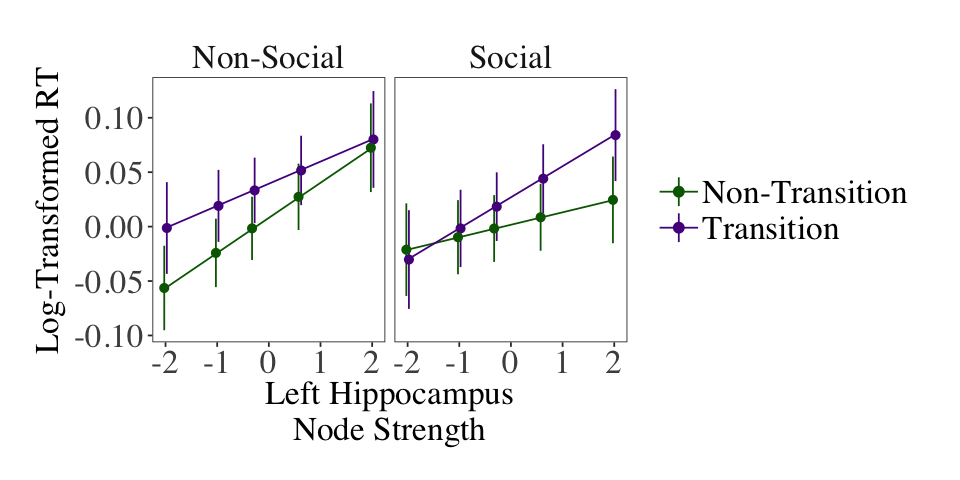

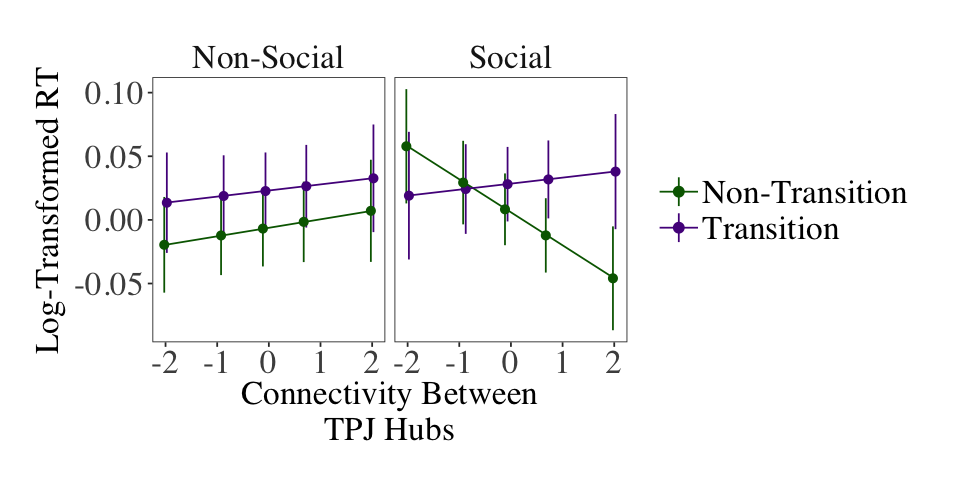

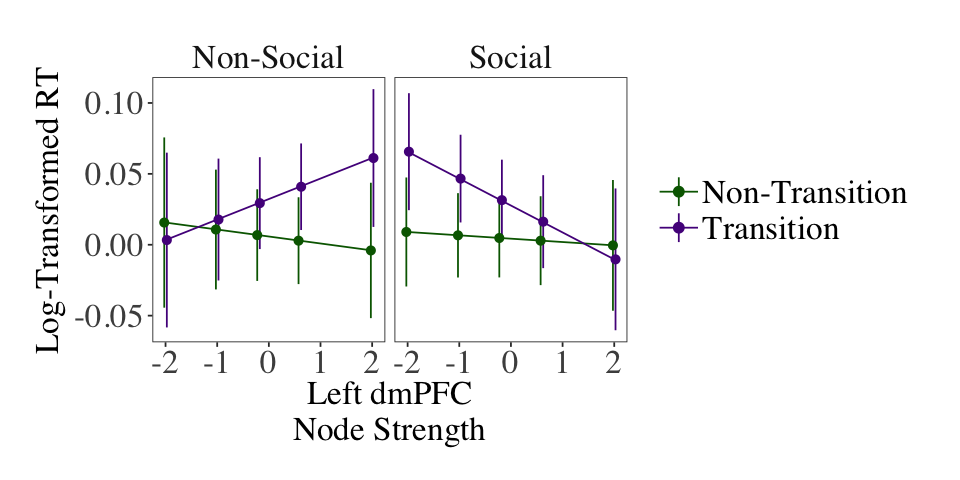

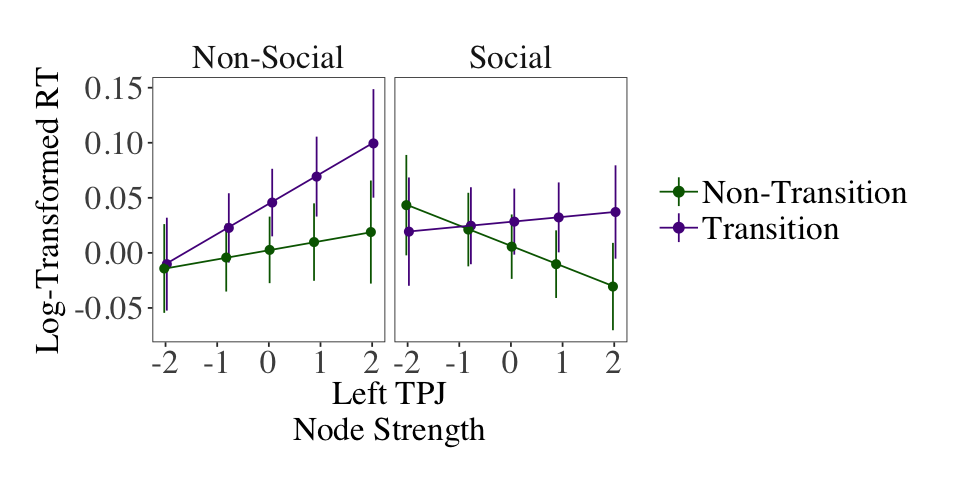

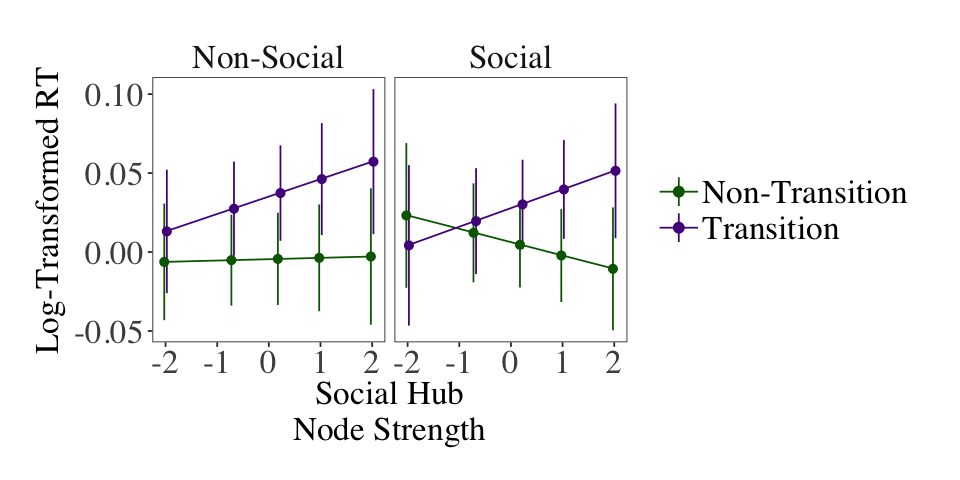

In [167]:

# Set figure size
options(repr.plot.width=8, repr.plot.height=4)

# Function to extract estimated marginal means and plot
plot_lmer_int<-function(mmod,pvar,xlabels,ylabels){
  e1<-Effect(list('grouping','Cond',pvar),mmod)
  # allEffects() returns a list, but for our model (where everything can interact with everything), there's only one element
  e1.df <- as.data.frame(e1)
  e1.df$grouping<-replace(as.character(e1.df$grouping),e1.df$grouping=='x','non-transition')
  e1.df$Cond<-replace(as.character(e1.df$Cond),e1.df$Cond=='NS','Non-Social')
  e1.df$Cond<-replace(as.character(e1.df$Cond),e1.df$Cond=='Soc','Social')
  
  e1.df$upper<- e1.df$fit + e1.df$se
  e1.df$lower<- e1.df$fit - e1.df$se
  
  g1 <- ggplot(e1.df,aes_string(x=pvar,y="fit",color="grouping",ymin="lower",ymax="upper")) + 
    geom_pointrange(position=position_dodge(width=.1),fatten=3.0) + geom_line() +
    scale_colour_manual(name  ="Node Type",
                        labels=c("Non-Transition", "Transition"),
                        #values = c("#003300","#333009")) +
                        values = c("darkgreen","purple4")) +
    facet_wrap(~Cond) + xlab(xlabels) + ylab(ylabels) + 
    theme(plot.title = element_text(hjust = 0.5), text = element_text(size=15), 
          plot.background = element_blank(), 
          panel.grid.major = element_blank(), panel.grid.minor = element_blank(), 
          #legend.title=element_blank(),
          panel.border = element_blank(), panel.background = element_blank(), 
          axis.line = element_line(size=.2)) + theme_apa2(fsize=20,legend.pos = "right")
  

  plot(g1)
  return(g1)
}

# Plots for four significant moderating effects of brain connectivity
p1<-plot_lmer_int(mm_hipp,"Hippocampus_L_global_z",xlabels="Left Hippocampus\nNode Strength",ylabels="Log-Transformed RT")
p2<-plot_lmer_int(mm_ws_sochubs,"ws_sochubs_z",xlabels="Connectivity Between\nTPJ Hubs",ylabels="Log-Transformed RT")
p3<-plot_lmer_int(mm_dmPFC,"dmPFC_L_global_z",xlabels="Left dmPFC\nNode Strength",ylabels="Log-Transformed RT")
p4<-plot_lmer_int(mm_TPJ,"TPJ_L_global_z",xlabels="Left TPJ\nNode Strength",ylabels="Log-Transformed RT")
p5<-plot_lmer_int(mm_sochubs_gc,"diffhubs_global_z",xlabels="Social Hub\nNode Strength",ylabels="Log-Transformed RT")

In [170]:
fig_dir<-"/Users/steventompson/Git/tompson_netlearn_fmri/Figures/component_figs/"
ggsave(filename = paste(fig_dir,'fig6_hipp.svg',sep=""),plot = p1,device = 'svg', width= 8, height=4, units = 'in')
ggsave(filename = paste(fig_dir,'fig6_ws_sochubs.svg',sep=""),plot = p2,device = 'svg', width= 8, height=4, units = 'in')
ggsave(filename = paste(fig_dir,'fig6_dmPFC.svg',sep=""),plot = p3,device = 'svg', width= 8, height=4, units = 'in')
ggsave(filename = paste(fig_dir,'fig6_TPJ.svg',sep=""),plot = p4,device = 'svg', width= 8, height=4, units = 'in')
ggsave(filename = paste(fig_dir,'fig6_sochubs_gc.svg',sep=""),plot = p5,device = 'svg', width= 8, height=4, units = 'in')

In [158]:
?ggsave

ggsave {ggplot2},R Documentation
filename,File name to create on disk.
plot,"Plot to save, defaults to last plot displayed."
device,"Device to use. Can be either be a device function (e.g. png()), or one of ""eps"", ""ps"", ""tex"" (pictex), ""pdf"", ""jpeg"", ""tiff"", ""png"", ""bmp"", ""svg"" or ""wmf"" (windows only)."
path,Path to save plot to (combined with filename).
scale,Multiplicative scaling factor.
"width, height, units","Plot size in units (""in"", ""cm"", or ""mm""). If not supplied, uses the size of current graphics device."
dpi,"Plot resolution. Also accepts a string input: ""retina"" (320), ""print"" (300), or ""screen"" (72). Applies only to raster output types."
limitsize,"When TRUE (the default), ggsave will not save images larger than 50x50 inches, to prevent the common error of specifying dimensions in pixels."
...,"Other arguments passed on to the graphics device function, as specified by device."


# Print full model output for each model

In [89]:
for(x in hublist){
    output<-summary(full_model_output[[paste('all',x,sep='_')]])$coefficient[c(6),]
    #row.names(output)<-gsub(" ","",row.names(output))
    #row.names(output)<-gsub("combData2_ss","",row.names(output))
    #row.names(output)<-gsub("combData2_gc","",row.names(output))
    
    print(paste(x,'_Main_Effect',sep=""))
    print(round(output,digits=3))
    print('')
}

[1] "combhubs_global_z_Main_Effect"
  Estimate Std. Error         df    t value   Pr(>|t|) 
     0.003      0.010     23.915      0.293      0.772 
[1] ""
[1] "Hippocampus_L_global_z_Main_Effect"
  Estimate Std. Error         df    t value   Pr(>|t|) 
     0.021      0.011     25.168      1.943      0.063 
[1] ""
[1] "Hippocampus_R_global_z_Main_Effect"
  Estimate Std. Error         df    t value   Pr(>|t|) 
     0.006      0.009     24.701      0.629      0.535 
[1] ""
[1] "diffhubs_global_z_Main_Effect"
  Estimate Std. Error         df    t value   Pr(>|t|) 
     0.000      0.011     25.655      0.009      0.993 
[1] ""
[1] "TPJ_L_global_z_Main_Effect"
  Estimate Std. Error         df    t value   Pr(>|t|) 
     0.004      0.011     24.827      0.333      0.742 
[1] ""
[1] "TPJ_R_global_z_Main_Effect"
  Estimate Std. Error         df    t value   Pr(>|t|) 
     0.004      0.011     25.680      0.353      0.727 
[1] ""
[1] "diffhubs_ns_global_z_Main_Effect"
  Estimate Std. Error      

In [90]:
for(x in hublist){
    output<-summary(full_model_output[[paste('all',x,sep='_')]])$coefficient[c(13),]
    #row.names(output)<-gsub(" ","",row.names(output))
    #row.names(output)<-gsub("combData2_ss","",row.names(output))
    #row.names(output)<-gsub("combData2_gc","",row.names(output))
    
    print(paste('NodeTypex',x,sep=""))
    print(round(output,digits=3))
    print('')
}

[1] "NodeTypexcombhubs_global_z"
  Estimate Std. Error         df    t value   Pr(>|t|) 
     0.002      0.003    293.818      0.883      0.378 
[1] ""
[1] "NodeTypexHippocampus_L_global_z"
  Estimate Std. Error         df    t value   Pr(>|t|) 
     0.001      0.003    139.793      0.497      0.620 
[1] ""
[1] "NodeTypexHippocampus_R_global_z"
  Estimate Std. Error         df    t value   Pr(>|t|) 
     0.002      0.003    334.954      0.728      0.467 
[1] ""
[1] "NodeTypexdiffhubs_global_z"
  Estimate Std. Error         df    t value   Pr(>|t|) 
     0.008      0.003    190.896      2.730      0.007 
[1] ""
[1] "NodeTypexTPJ_L_global_z"
  Estimate Std. Error         df    t value   Pr(>|t|) 
     0.011      0.003    253.818      4.018      0.000 
[1] ""
[1] "NodeTypexTPJ_R_global_z"
  Estimate Std. Error         df    t value   Pr(>|t|) 
     0.006      0.003    178.546      2.069      0.040 
[1] ""
[1] "NodeTypexdiffhubs_ns_global_z"
  Estimate Std. Error         df    t value   Pr

In [91]:
for(x in hublist){
    output<-summary(full_model_output[[paste('all',x,sep='_')]])$coefficient[c(21),]
    #row.names(output)<-gsub(" ","",row.names(output))
    #row.names(output)<-gsub("combData2_ss","",row.names(output))
    #row.names(output)<-gsub("combData2_gc","",row.names(output))
    
    print(paste('NodeTypexNetworkType',x,sep=""))
    print(round(output,digits=3))
    print('')
}

[1] "NodeTypexNetworkTypecombhubs_global_z"
  Estimate Std. Error         df    t value   Pr(>|t|) 
     0.001      0.003    159.367      0.272      0.786 
[1] ""
[1] "NodeTypexNetworkTypeHippocampus_L_global_z"
  Estimate Std. Error         df    t value   Pr(>|t|) 
     0.007      0.003    231.158      2.571      0.011 
[1] ""
[1] "NodeTypexNetworkTypeHippocampus_R_global_z"
  Estimate Std. Error         df    t value   Pr(>|t|) 
     0.005      0.003    103.790      1.748      0.083 
[1] ""
[1] "NodeTypexNetworkTypediffhubs_global_z"
  Estimate Std. Error         df    t value   Pr(>|t|) 
     0.002      0.003    188.560      0.697      0.487 
[1] ""
[1] "NodeTypexNetworkTypeTPJ_L_global_z"
  Estimate Std. Error         df    t value   Pr(>|t|) 
     0.000      0.003    108.466      0.152      0.880 
[1] ""
[1] "NodeTypexNetworkTypeTPJ_R_global_z"
  Estimate Std. Error         df    t value   Pr(>|t|) 
     0.003      0.003    185.538      0.917      0.360 
[1] ""
[1] "NodeTypexNetw

In [138]:
for(x in sighubs){
    output1<-summary(full_model_output[[paste('all',x,sep='_')]])$coefficient[13,]
    output2<-summary(full_model_output[[paste('all',x,sep='_')]])$coefficient[21,]
    output3<-summary(full_model_output[[paste('soc',x,sep='_')]])$coefficient[9,]
    output4<-summary(full_model_output[[paste('ns',x,sep='_')]])$coefficient[9,]
    #row.names(output)<-gsub(" ","",row.names(output))
    #row.names(output)<-gsub("combData2_ss","",row.names(output))
    #row.names(output)<-gsub("combData2_gc","",row.names(output))
    print(x)
    print('2-way GxB interaction')
    print(round(output1,digits=3))   
    print('3-way GxBxC interaction')
    print(round(output2,digits=3))   
    print('Social NodeType x Connectivity Interaction')
    print(round(output3,digits=3))
    print('Non-Social NodeType x Connectivity Interaction')
    print(round(output4,digits=3))
    print('')
}

[1] "diffhubs_global_z"
[1] "2-way GxB interaction"
  Estimate Std. Error         df    t value   Pr(>|t|) 
     0.008      0.003    190.896      2.730      0.007 
[1] "3-way GxBxC interaction"
  Estimate Std. Error         df    t value   Pr(>|t|) 
     0.002      0.003    188.560      0.697      0.487 
[1] "Social NodeType x Connectivity Interaction"
  Estimate Std. Error         df    t value   Pr(>|t|) 
     0.008      0.004     25.315      1.741      0.094 
[1] "Non-Social NodeType x Connectivity Interaction"
  Estimate Std. Error         df    t value   Pr(>|t|) 
     0.006      0.005     20.891      1.200      0.243 
[1] ""
[1] "TPJ_L_global_z"
[1] "2-way GxB interaction"
  Estimate Std. Error         df    t value   Pr(>|t|) 
     0.011      0.003    253.818      4.018      0.000 
[1] "3-way GxBxC interaction"
  Estimate Std. Error         df    t value   Pr(>|t|) 
     0.000      0.003    108.466      0.152      0.880 
[1] "Social NodeType x Connectivity Interaction"
  Estimat

In [137]:
print(round(gxb_fdr_pvals_soc,3))
print(round(gxb_fdr_pvals_ns,3))

[1] 0.117 0.046 0.071 0.512 0.019
[1] 0.528 0.197 0.532 0.528 0.556


In [152]:
pvals1<-data.frame(gxb_fdr_pvals_all[match(sighubs,hublist)])
row.names(pvals1)<-sighubs
round(pvals1,3)

,gxb_fdr_pvals_all.match.sighubs..hublist..
diffhubs_global_z,0.049
TPJ_L_global_z,0.001
Hippocampus_L_global_z,0.698
dmPFC_L_global_z,0.698
ws_sochubs_z,0.126


In [153]:
pvals1<-data.frame(gxbxc_fdr_pvals_all[match(sighubs,hublist)])
row.names(pvals1)<-sighubs
round(pvals1,3)

,gxbxc_fdr_pvals_all.match.sighubs..hublist..
diffhubs_global_z,0.679
TPJ_L_global_z,0.880
Hippocampus_L_global_z,0.050
dmPFC_L_global_z,0.033
ws_sochubs_z,0.033


In [103]:
round(b_me_fdr_pvals_all,3)

[1] 0.922 0.856 0.922 0.993 0.922 0.922 0.856 0.967 0.922 0.922 0.922 0.922
[13] 0.856 0.922

In [104]:
round(gxb_fdr_pvals_all,3)

[1] 0.529 0.698 0.594 0.049 0.001 0.137 0.137 0.698 0.137 0.137 0.308 0.529
[13] 0.760 0.126

In [105]:
round(gxbxc_fdr_pvals_all,3)

[1] 0.846 0.050 0.233 0.679 0.880 0.679 0.679 0.033 0.679 0.101 0.679 0.679
[13] 0.679 0.033